In [1]:
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt
import stylised_facts_data_utilities.TukeyGH as tukey
from tqdm.auto import tqdm
import pandas as pd
import time

### Metrics for comparing distrubtions

In [2]:
def KS_test(estimated_params, params_i):
    x = np.linspace(-10, 10, 500)
    estimated_cdf = tukey.pgh(x, estimated_params['loc'], estimated_params['scale'], estimated_params['g'], estimated_params['h'])
    true_cdf = tukey.pgh(x, params_i[0], params_i[1], params_i[2], params_i[3])
    return np.max( np.abs(estimated_cdf - true_cdf))

In [3]:
def KL_divergence( estimated_params, params_i):
    x = np.linspace(-10, 10, 500)
    dx = x[1] - x[0]
    estimated_pdf = tukey.dgh(x, estimated_params['loc'], estimated_params['scale'], estimated_params['g'], estimated_params['h'])
    true_pdf = tukey.dgh(x, params_i[0], params_i[1], params_i[2], params_i[3])
    distance_KL = estimated_pdf * np.log(estimated_pdf/true_pdf) * dx
    return distance_KL.sum()

### Run and test different algorithms

In [4]:
def test_algo(algo, n_exp=2, display_graph=False):
    
    n_samples = 500
    original_params = np.array([0.04, 0.04, 1, 0.3])
    pertubation = stats.norm(loc=0, scale=[0.01, 0.01, 0.1, 0.1])
    x_plot = np.linspace( -0.5, 0.5, 200)
    n_rows = int(np.ceil(n_exp/2))
    error = np.zeros((n_exp, 2))
    
    if display_graph:
        fig, axes = plt.subplots( nrows=n_rows, ncols=2, figsize=(20, 4*n_rows))
        axes = axes.flatten()
        
    start_time = time.time()
    
    for i in tqdm(range(n_exp)):
        params_i = original_params + pertubation.rvs(4)
        
        x_i = tukey.rgh(n_samples, params_i[0], params_i[1], params_i[2], params_i[3], c=0.8 )
        if algo == 'QLS':
            estimated_params = tukey.estimate_qls(x_i)
        if algo == 'MCMC':
            _, estimated_params = tukey.estimate_mcmc(x_i, N=2000, theta0=np.array([x_i.mean(), x_i.std(), 0, 0]), Sigma0=1e-3*np.eye(4))
        if algo == 'ABC':
            rprior = lambda n : stats.uniform.rvs(loc=np.array([0, 0, -3, 0]), scale=np.array([0.2, 0.2, 6, 2]), size=(n, 4))
            _, estimated_params = tukey.estimateABC( x_i, N=5e4, rprior=rprior, M=100, statsType=tukey._ABCStatsMethod.ALL_STATS, batchSize=1000)
        if algo == 'MCMC_ABC':
            rprior = lambda n : stats.uniform.rvs(loc=np.array([0, 0, -3, 0]), scale=np.array([0.2, 0.2, 6, 2]), size=(n, 4))
            output_abc, estimated_params = tukey.estimateABC( x_i, N=5e4, rprior=rprior, M=100, statsType=tukey._ABCStatsMethod.ALL_STATS, batchSize=1000)
            
            theta0 = np.array([estimated_params['loc'], estimated_params['scale'], estimated_params['g'], estimated_params['h']])
            Sigma0 = np.cov(output_abc[:, :4].T)
            _, estimated_params = tukey.estimate_mcmc( x_i, N=2000, theta0=theta0, Sigma0=Sigma0)
        if algo == 'FDSA':
            estimated_params = tukey.estimate_fdsa(np.random.choice(x_i, 50, replace=True), N=100,
                                                   theta0=np.array([x_i.mean(), x_i.std(), 0, 1e-5]),
                                                   theta_min=np.array([0, 1e-5, -2, 0]),
                                                   theta_max=np.array([0.1, 0.1, 2, 1]),
                                                   a0=0.001,
                                                   resDict=True)
        error[i, :] = np.array([KS_test(estimated_params, params_i), KL_divergence(estimated_params, params_i)])
        
        if display_graph:
            estimated_pdf = tukey.dgh(x_plot, estimated_params['loc'], estimated_params['scale'], estimated_params['g'], estimated_params['h'])
            true_pdf = tukey.dgh(x_plot, params_i[0], params_i[1], params_i[2], params_i[3])
            
            axes[i].plot(x_plot, estimated_pdf, color='red', label='estimated')
            axes[i].plot(x_plot, true_pdf, color='blue', label='true')
            axes[i].fill_between(x_plot, true_pdf, 0, color='black', alpha=0.1)
            axes[i].legend()
            
    mean_time = (time.time() - start_time)/n_exp
    mean_error = np.abs(error).mean(axis=0)
        
    resDict = dict(zip(['algo', 'KS', 'KL', 'time'], [algo, mean_error[0], mean_error[1], mean_time]))
    return resDict

In [5]:
import scipy.stats as stats

In [6]:
stats?

### QLS

/home/ak/Documents/Research/PaperCode/stylised_facts/stylised_facts_data_utilities/TukeyGH/__init__.py:30: RuntimeWarning: overflow encountered in exp
  term2 = z * np.exp(0.5 * h * z ** 2)


{'algo': 'QLS',
 'KS': 0.032156010029072174,
 'KL': 0.06736077357739649,
 'time': 0.5611141920089722}

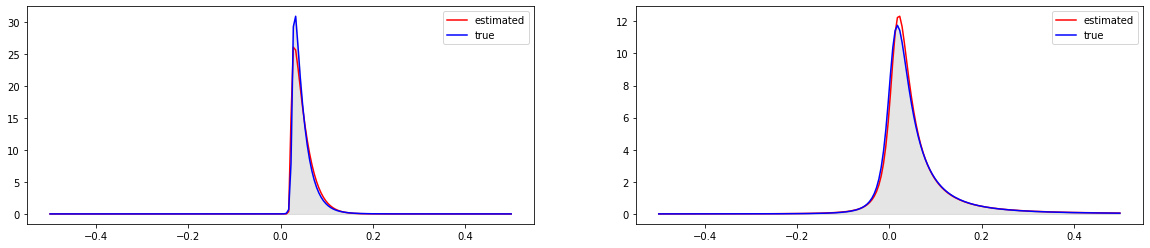

In [7]:
test_algo( 'QLS', n_exp=2, display_graph=True )

### ABC method

{'algo': 'ABC',
 'KS': 0.046983134723575654,
 'KL': 0.02994090304339067,
 'time': 12.340065836906433}

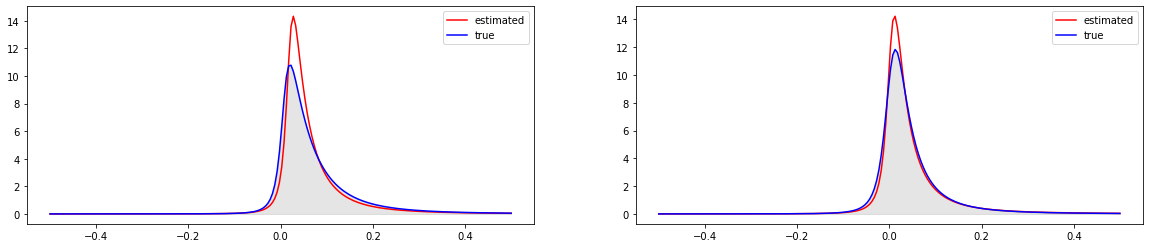

In [8]:
test_algo( 'ABC', n_exp=2, display_graph=True )

### MCMC method

/home/ak/Documents/Research/PaperCode/stylised_facts/stylised_facts_data_utilities/TukeyGH/__init__.py:30: RuntimeWarning: overflow encountered in double_scalars
  term2 = z * np.exp(0.5 * h * z ** 2)


{'algo': 'MCMC',
 'KS': 0.07100373029537617,
 'KL': 0.05387156562343115,
 'time': 27.000257968902588}

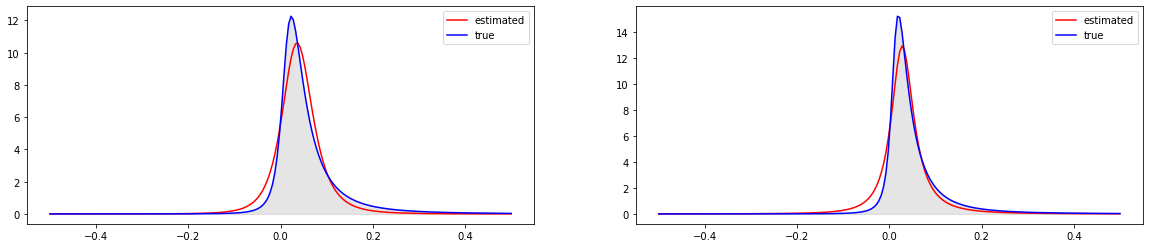

In [9]:
test_algo( 'MCMC', n_exp=2, display_graph=True )

### ABC + MCMC method

In [ ]:
test_algo( 'MCMC_ABC', n_exp=2, display_graph=True )